# SED Fitting using Advanced Techniques: Dynamic Nested Sampling

### Background

The Spectral Energy Distribution (SED) of a galaxy shows the distribution of energy over wavelength/frequency. SEDs are shaped by many of the fundamental physical properties of galaxies such as their star formation history, chemical enrichment history, age, dust absorption, dust emission, stellar initial mass function, and stellar mass (see figure below for an illustration). The goal of SED modeling is to extract these physical properties from the observed SEDs of galaxies. Over the past few decades, many different methods have been developed to fit the SEDs of galaxies (see Conroy 2013 for a review).

<font color='mediumblue'>Caption: These figures are selected from Leja et al. 2017. They show model SEDs with three different values for each parameter while keeping all other parameters constant (e. g. stellar mass, stellar metallicity, diffuse dust, and dust emission). This illustrates how different parameters change the shape of a galaxy's SED. These models were generated using $\mathtt{FSPS}$ and are available as free parameters in the SED fitting code $\mathtt{Prospector}$, see below for discussion of these programs.</font>

<img src="CWoodrum_figures/leja2017d.png" width="1600" />

<img src="Cwoodrum_figures/leja2017c.png" width="1800" />

<img src="Cwoodrum_figures/leja2017b.png" width="1800" />

<img src="Cwoodrum_figures/leja2017a.png" width="1800" />

### Prospector

$\mathtt{Prospector}$ is a python-based SED fitting code that uses a Bayesian inference framework (Leja et al. 2017). It allows the user to infer high-dimensional galaxy properties from their observed photometry and/or spectroscopy. Prospector uses the Flexible Stellar Population Synthesis ($\mathtt{FSPS}$) stellar population code (Conroy et al. 2009) via $\mathtt{python-FSPS}$ (Foreman-Mackey et al. 2014). The posteriors are sampled using the dynamic nested sampling code $\mathtt{dynesty}$ (with $\mathtt{emcee}$ being an option, as well). Most SED fitting techniques use pre-generated grid templates that rely on strong assumptions and complex priors. Additionally, their size grows exponentially with model dimensionality. The power of $\mathtt{Prospector}$ comes from the combination of on-the-fly stellar population synthesis and the exploration of parameter space with a dynamic nested sampling algorithm. This increased flexibility comes at the cost of increased computational time.

# Dynamic Nested Sampling

With the quantity and quality of data significantly increasing in recent times, astronomers have started to use Bayesian approaches instead of frequentist methods for their statistical inference frameworks. The most popular Bayesian approach is called the Markov Chain Monte Carlo (MCMC) method, which many of us have learned about in multiple classes. Another Bayesian approach is called nested sampling (Skilling 2004, 2006). MCMC methods sample from the posterior directly, while nested sampling takes a different approach by focusing on estimating the evidence, described below from Speagle (2020):

1. ‘slicing’ the posterior into many simpler distributions
2. sampling from each of those in turn
3. re-combining the results afterwards

The following is an illustration from Speagle 2020

<img src="CWoodrum_figures/speagle2020.png" width="1600" />

Leja et al. 2019 succinctly describe the reasons they choose to use nested sampling for $\mathtt{Prospector}$ in the following paragraph:
"Nested sampling has a number of desirable properties over standard MCMC sampling, including 
1. well-defined stopping criteria
2. easier access to independent samples
3. more sophisticated treatment of multimodal solutions
4. and simultaneous estimation of the Bayesian evidence. 

Additionally, dynamic nested sampling can be performed such that samples are targeted adaptively during the fit to better sample specific areas of the posterior. Finally, internal testing with $\mathtt{Prospector}$ shows that $\mathtt{dynesty}$ requires ∼2$\times$ fewer model calls to produce similar posteriors to MCMC methods, which translates to a ~50% decrease in run time."

# Application to My Research

### Data
The data used in this example come from The Large Early Galaxy Census (LEGA-C) Survey (van der Wel et al. 2016). LEGA-C is a public spectroscopic survey of $\sim$3200 galaxies in the COSMOS field within the redshift range $0.6<z<1.0$ and stellar masses, $\mathrm{log\ M_*>10M_{\odot}}$. LEGA-C has produced 20-hour depth spectroscopy of galaxies to observed $\lambda \sim 8800 \mathring A$ with VIMOS on ESO's Very Large Telescope. The S/N of the LEGA-C data rivals that of local SDSS spectroscopy, typically $>10$. In addition, the LEGA-C galaxies have excellent ancillary data with deep near- and mid-infrared imaging from the UltraVISTA survey and Spitzer/SPLASH, as well as high-resolution HST imaging.

### Methods
In this example, I will be using $\mathtt{Prospector}$, utilizing the $\mathtt{dynesty}$ dynamic nested sampling algorithm, to simultaneously fit the high resolution spectra and 26 photometric points of a LEGA-C galaxy at z=0.6. For my research, I am currently fitting 200 galaxies using the same methods and model below. 

### Model
* Basic Parameters
    1. IMF type: Chabrier (Chabrier 2003)
    2. Stellar library: MILES
    3. Redshift: A free parameter, allowed to wiggle between $\mathrm{z_{spec}-0.05 < z < z_{spec} + 0.05}$
    4. IGM Absorption: includes IGM absorption via Madau (1995). 
    5. AGB dust: uses the AGB circumstellar dust model presented in Villaume (2014)
<br>
* Star Formation History
    1. Continuity SFH:  A non-parametric SFH model of mass in fixed time bins with a smoothness prior
        * 5 agebins with the first two agebins hard-coded to be 0-30 Myr, 30-100 Myr and the final agebin is hard-coded to cover $\mathrm{0.85 \times t_{univ}-t_{univ}}$, the rest split in logarithmic time evenly
* Dust Absorption
    1. Dust Type: Kriek \& Conroy (2013) attenuation curve. In this model the slope of the curve, set by the parameter "dust index", is linked to the strength of the UV bump.
        * Dust Index: Free parameter, power-law multiplication of Calzetti where 0 would be the Calzetti curve
        * Dust 1: optical depth towards young stars. Dust parameter describing the attenuation of young stellar light
        * Dust 2: optical depth at 5500\AA. Dust parameter describing the attenuation of old stellar light
        * Dust Ratio: free parameter, ratio of birth-cloud to diffuse dust (dust 1 to dust 2).
* Dust Emission: the Draine & Li 2007 dust emission model (parameters are all fixed, not free)
* Nebular Emission: a nebular emission model (both continuum and line emission), based on Cloudy models from Nell Byler. 
* Gas Log Z: gas-phase metallicity as a free parameter
* Gas Log U: gas ionization as a free parameter
* Sigma Smooth: the velocity dispersion, in km/s, as a free parameter
* Calibration
    1. Spec Norm: Normalizes the continuum with a polynomial based on the polyorder (see below)
    2. Polyorder: a polynomial calibration vector, 10th order in this case
    3. Spec-Jitter: Roughly speaking this inflates the error bars such that $\mathrm{\chi^2 \sim 1}$. If spec-jitter = 1, there is no error inflation while if spec-jitter = 3, the errors are inflated by a factor of 3.
    4. f-Outlier-Spec: Pixel outlier model that essentially assumes each pixel has some chance to be an outlier, where outliers get highly inflated errors, and then marginalizes over this chance. f-Outlier-Spec is the fraction of pixels which are outliers (see Section 3 of [Hogg Bible](https://arxiv.org/pdf/1008.4686.pdf)).


In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *
%matplotlib inline
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
import prospect.io.read_results as reader
import matplotlib.pyplot as plt
from astropy.io import fits
plt.rcParams.update({'xtick.minor.visible': True, 'xtick.direction': "in", 'xtick.top': True, 
                    'ytick.minor.visible': True, 'ytick.direction': "in", 'ytick.right': True,
                    'xtick.major.size' : 7, 'xtick.minor.size' : 4, 'ytick.major.size' : 7, 'ytick.minor.size' : 4})
plt.rcParams.update({'font.size': 20}) #Makes all fonts bigger
plt.rcParams['text.usetex'] = True #allows you to use Latex
plt.rcParams['font.family'] = 'serif'

In [4]:
def imax(name):
    imax = np.argmax(name['lnprobability'])
    theta_max = name['chain'][imax, :].copy()
    return theta_max

def return_model(filename):
    res, obs, model = reader.results_from(filename)
    theta_max = imax(res)
    sps = reader.get_sps(res)
    spec, phot, mfrac = model.mean_model(theta_max, obs=res['obs'], sps=sps)
    return res, theta_max, spec, phot, model

resn5, thetamaxn5, specn5, photn5, modn5 = return_model("/home/cwoodrum/Documents/prospector_output_n5_172669.h5")


/home/cwoodrum/anaconda3/lib/python3.7/site-packages/prospect-0.3.0-py3.7.egg/prospect/io/read_results.py:290: UserWarning: Could not check SSP library versions.
  warnings.warn("Could not check SSP library versions.")


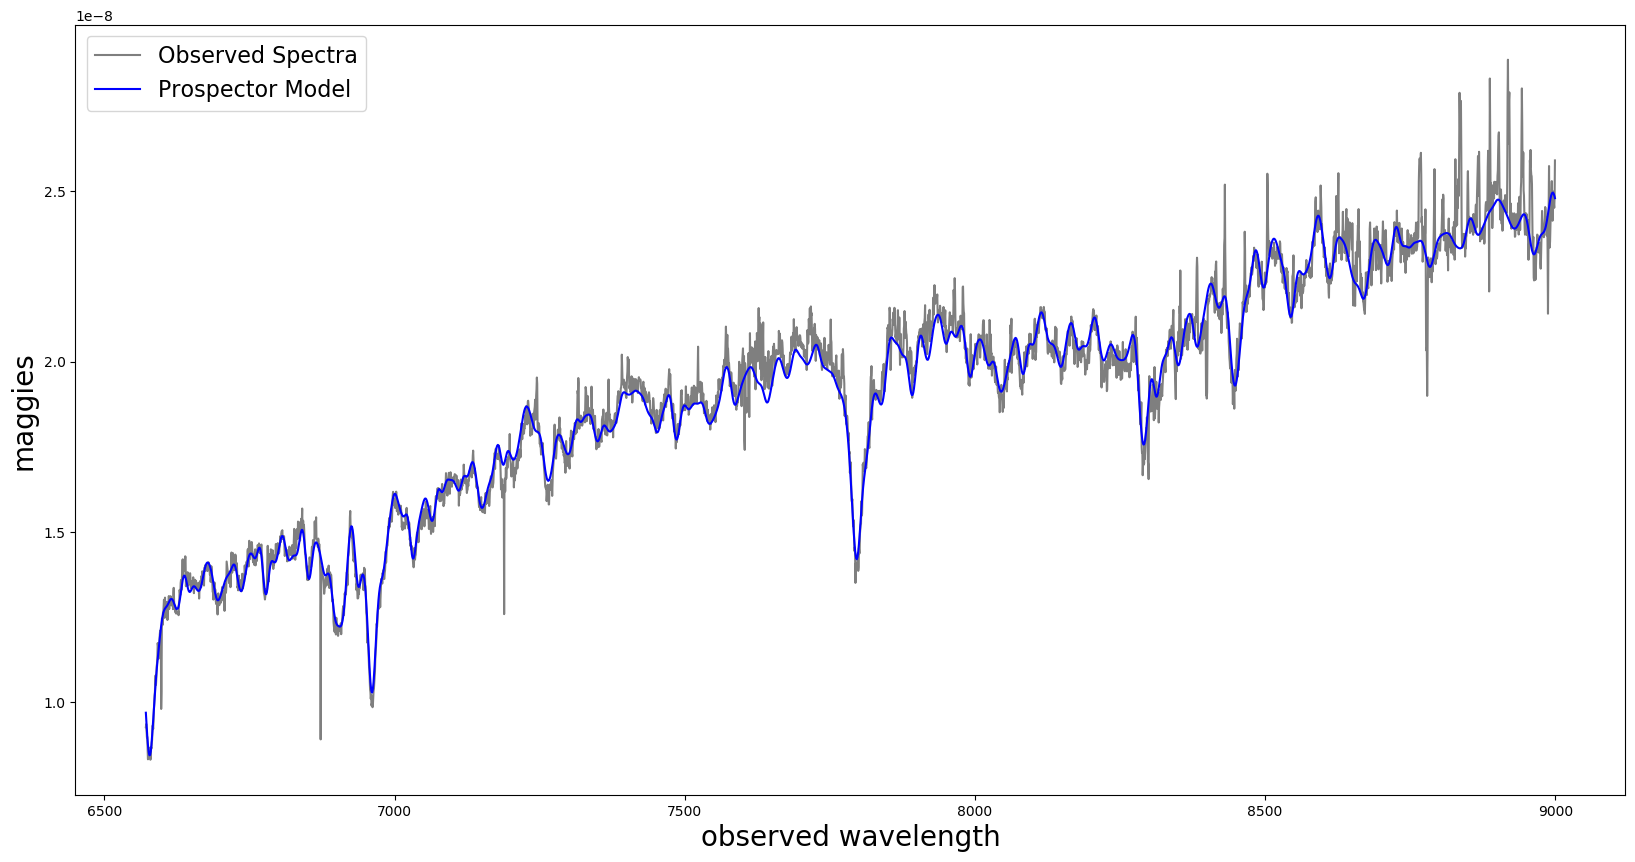

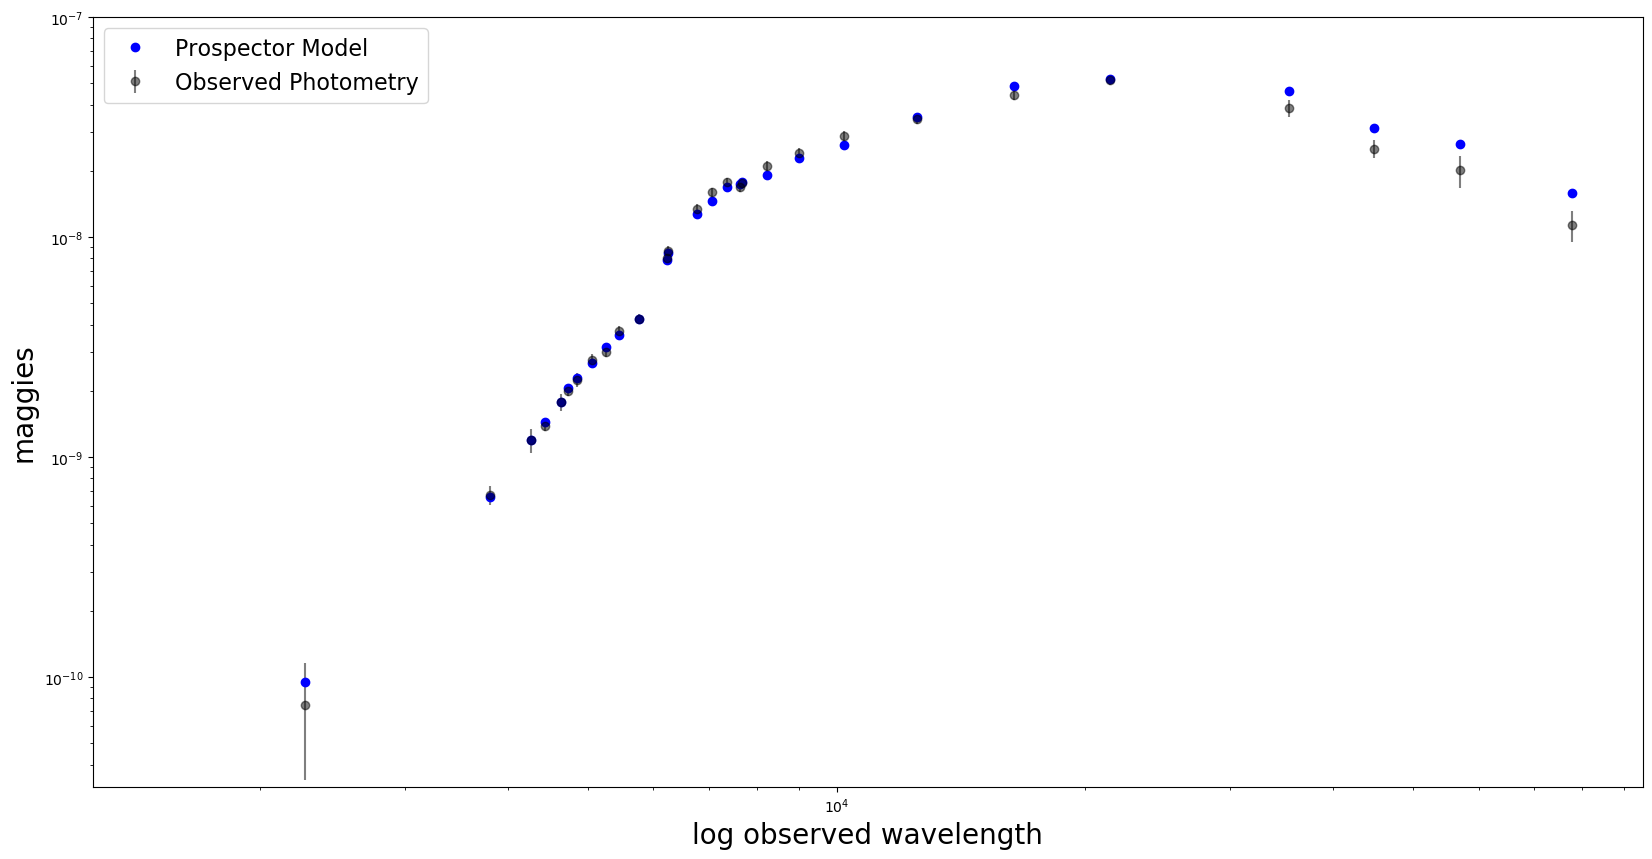

In [11]:
plt.style.use('default')
plt.figure(figsize=(20,10))
plt.plot(resn5['obs']['wavelength'], resn5['obs']['spectrum'], 'k-', label="Observed Spectra", alpha=0.5)
plt.plot(resn5['obs']['wavelength'], specn5, 'b-', label="Prospector Model")
plt.xlabel('observed wavelength', fontsize=20)
plt.ylabel('maggies', fontsize=20)
plt.legend(fontsize=16)
plt.show()

phot_wave = np.array([f.wave_effective for f in resn5['obs']["filters"]])
plt.figure(figsize=(20,10))
plt.errorbar(phot_wave, resn5['obs']['maggies'], xerr=None, yerr=resn5['obs']['maggies_unc'], marker='o', color='black',
            ls='none', capsize=0, label="Observed Photometry", alpha=0.5)
plt.plot(phot_wave, photn5, 'bo', label="Prospector Model")
plt.legend(fontsize=16)
plt.xscale('log')
plt.xlabel(r'log observed wavelength', fontsize=20)
plt.ylabel(r'maggies', fontsize=20)
plt.yscale('log')
plt.ylim(10**-10.5, 10**-7)
plt.show()

<font color='mediumblue'>Caption: The figure above shows the highest posterior probability model in the chain determined using $\mathtt{Prospector}$. The high S/N spectra and 26 photometric points were fit simultaneously. The models for both the spectra and photometry fit very well, with the exception of the four reddest photometric points. The uncertainties shown for these four points are significantly lower than what they should be (van der Wel, private correspondence), which explains the model deviation.</font>

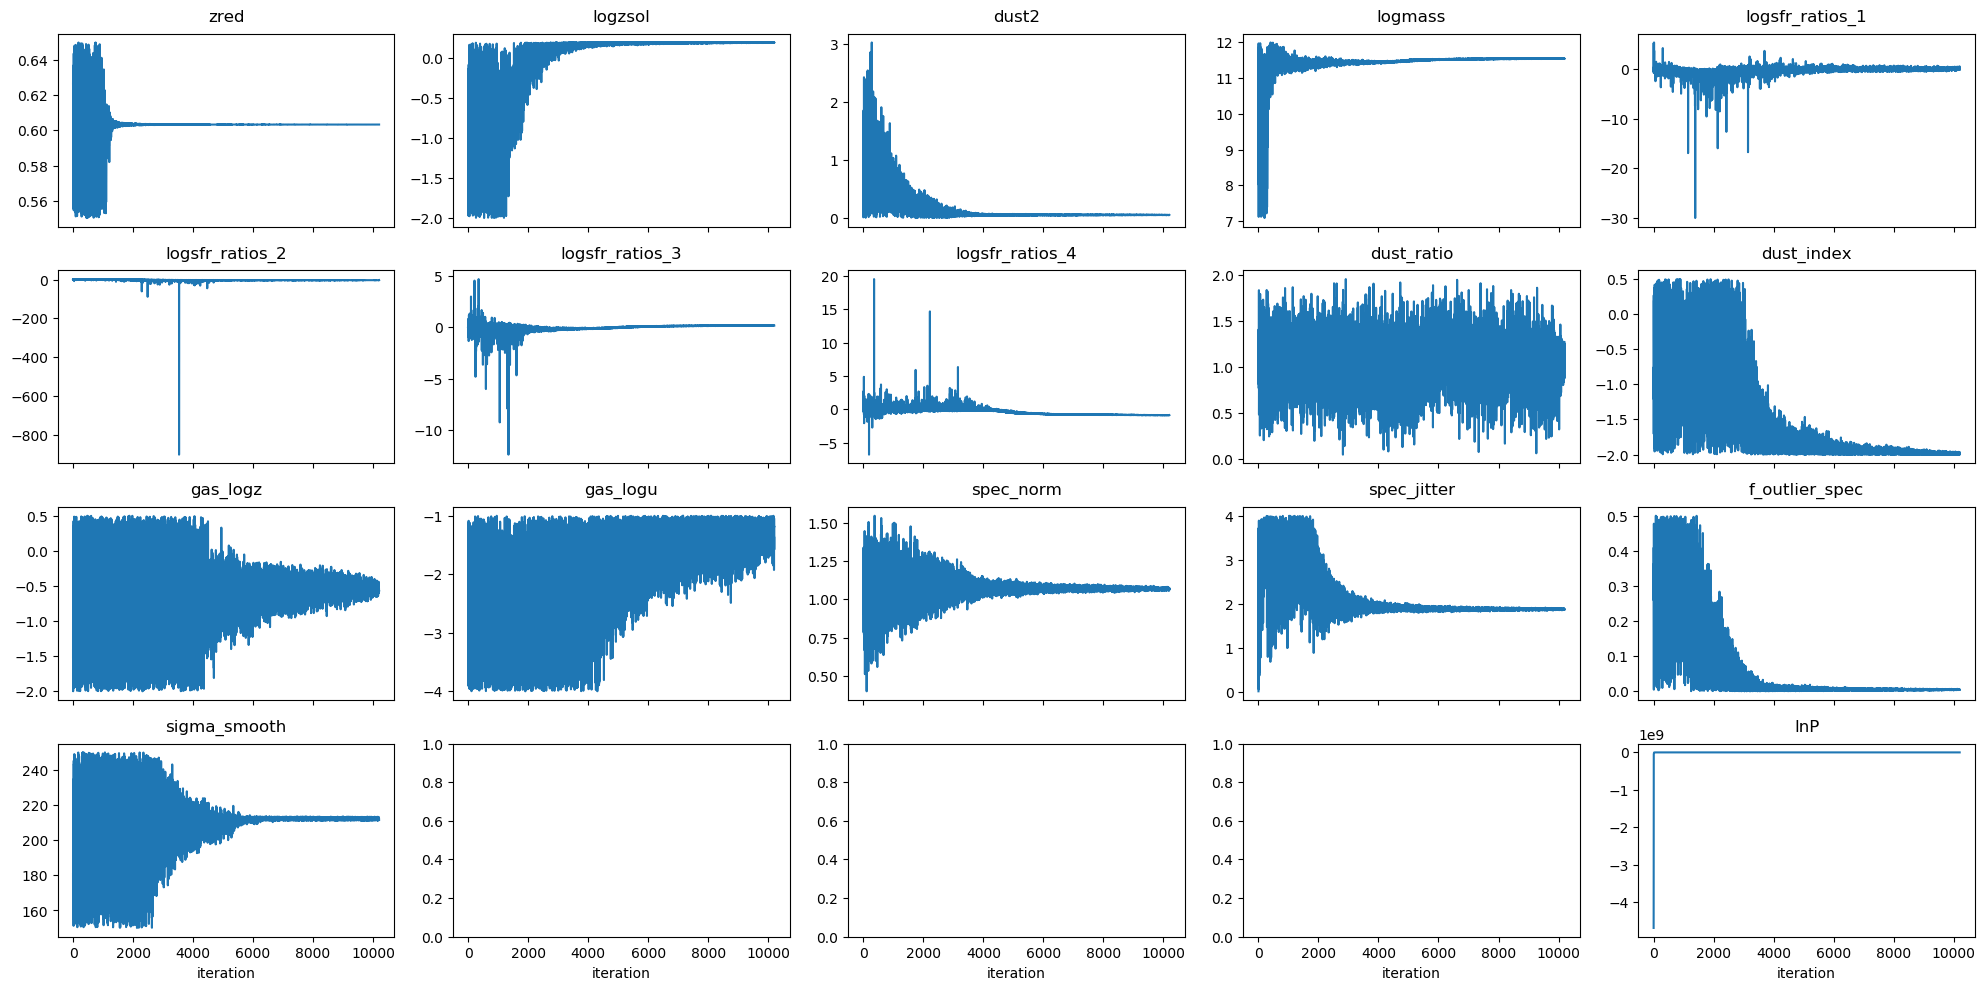

In [10]:
tracefig = reader.traceplot(resn5, figsize=(20,10))

<font color='mediumblue'>Caption: The figure above shows how the nested samples look and the evolution of the parameter value with iteration in the chain. You can see that most of the free parameters converge quite nicely. This was greatly improved when I switched from using $\mathtt{emcee}$ to $\mathtt{dynesty}$ (the dynamic nested sampling algorithm).</font>

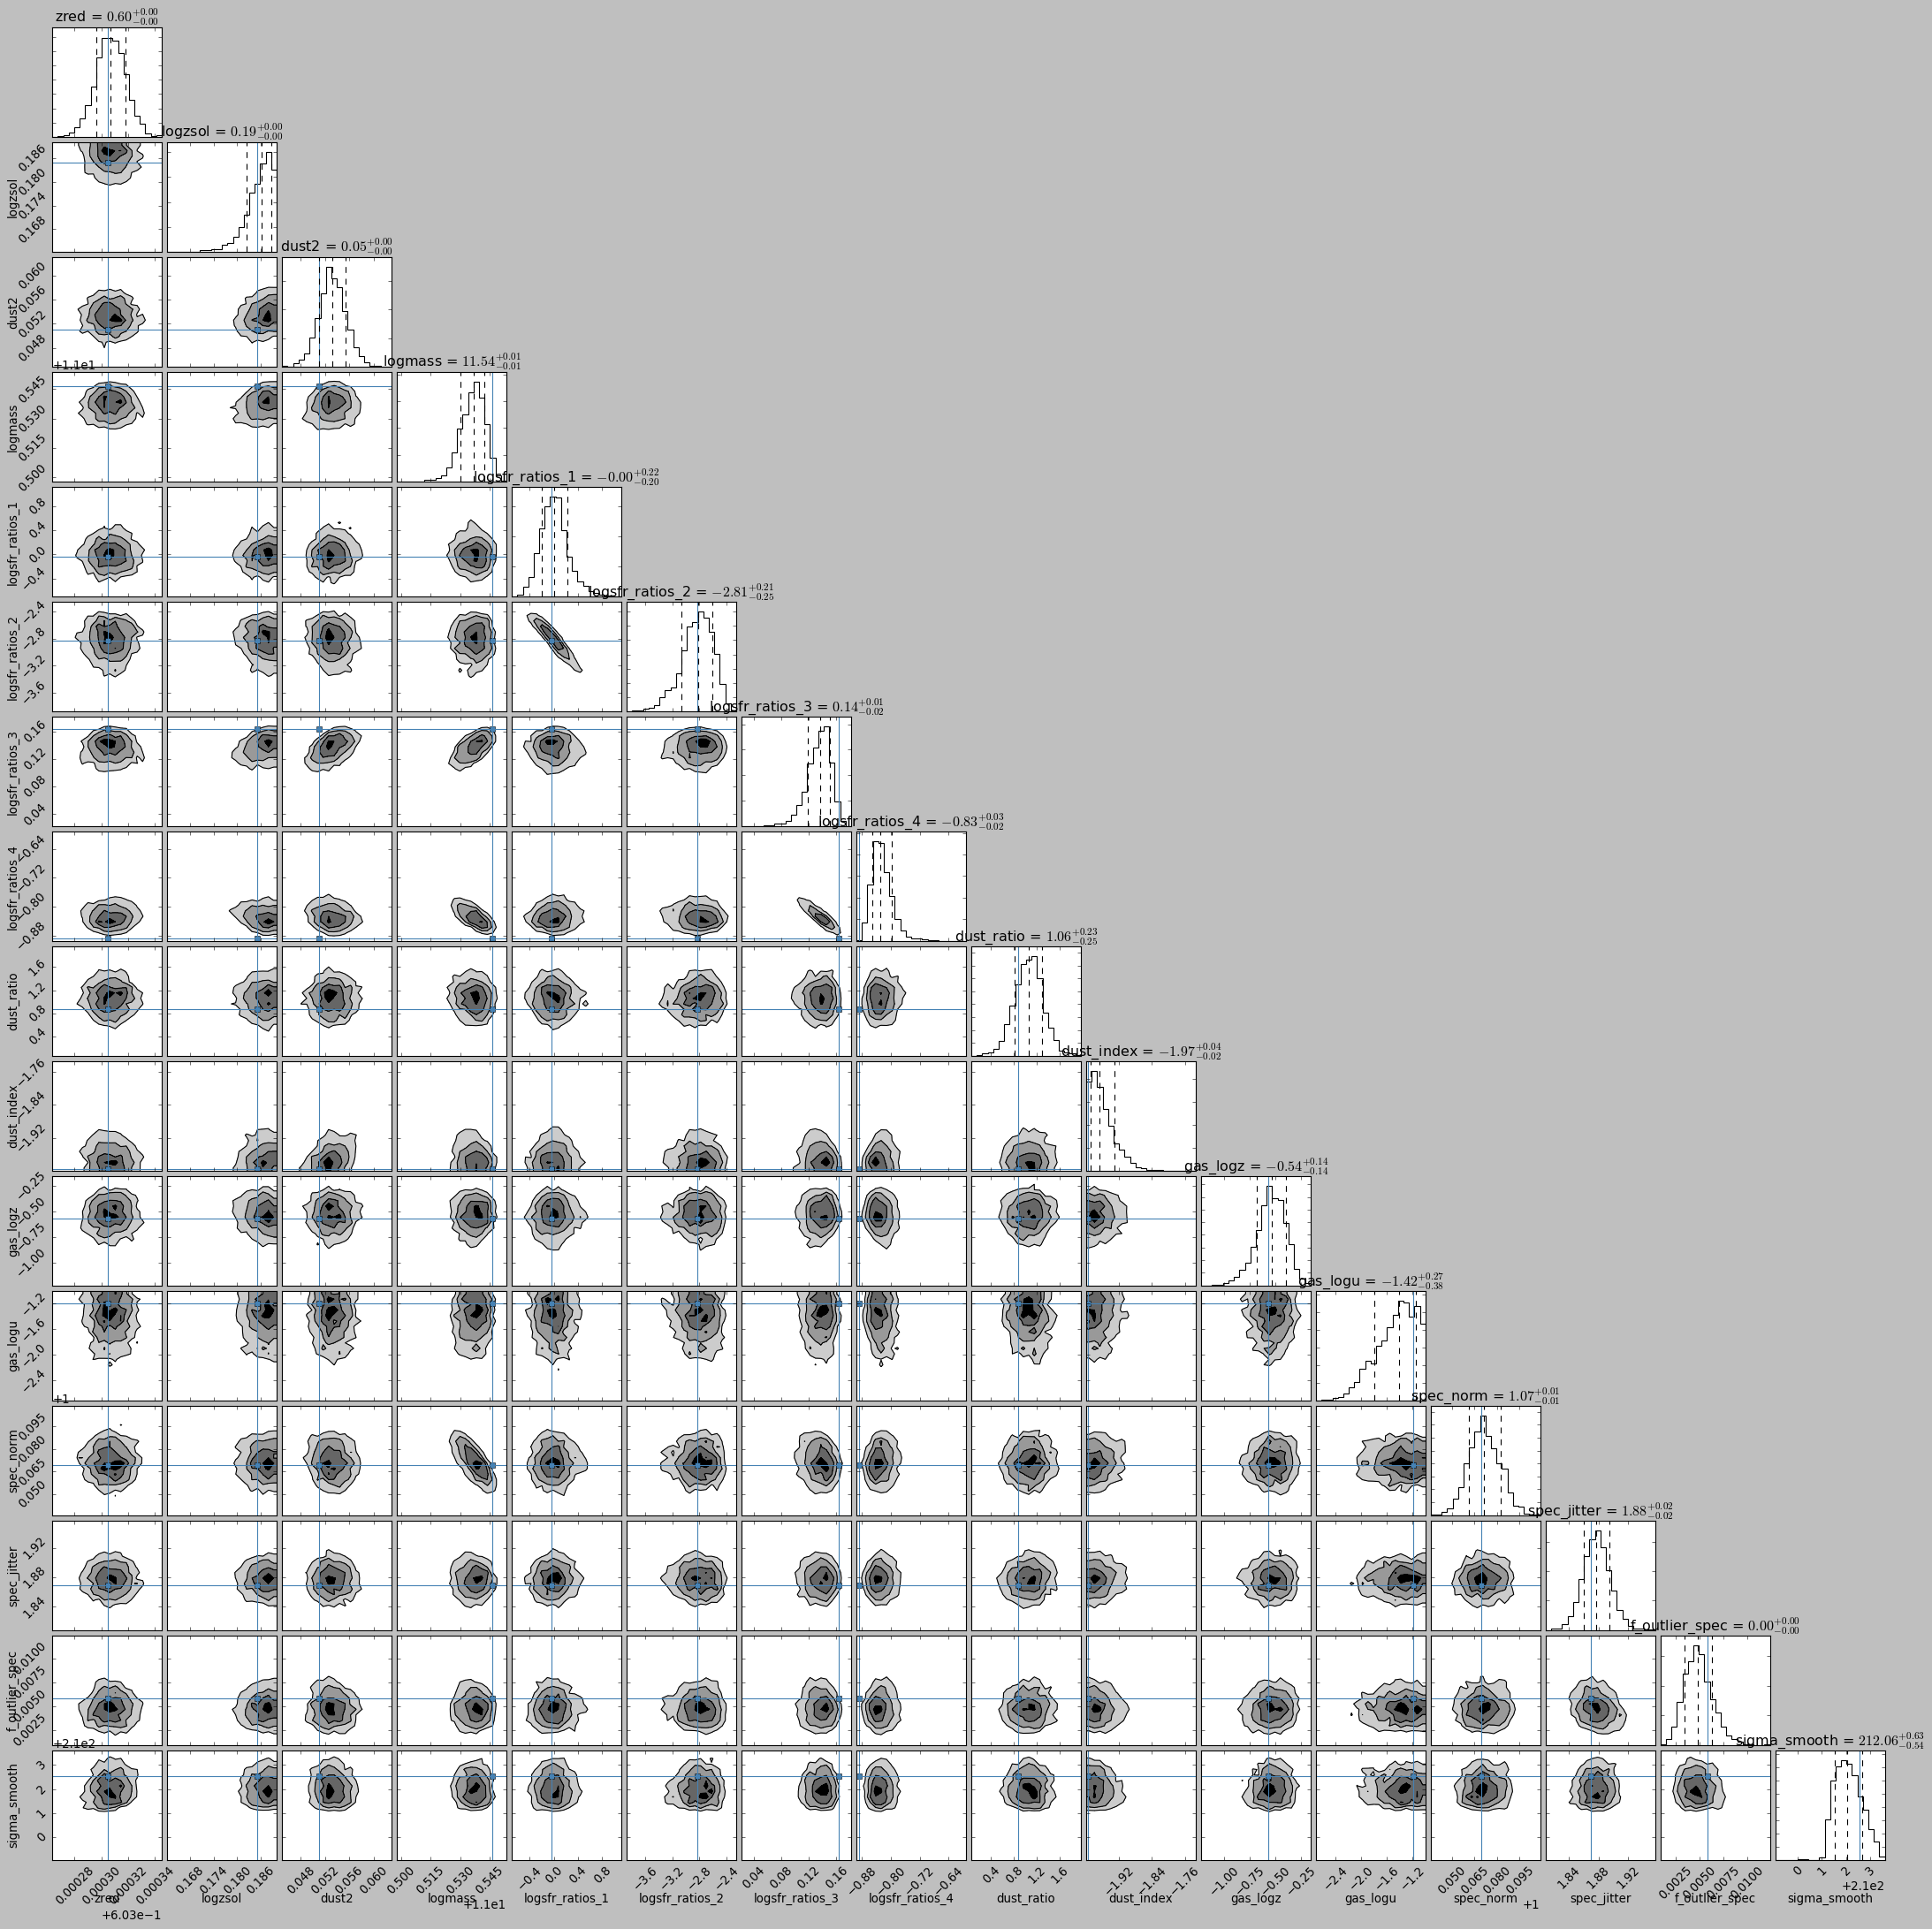

In [5]:
plt.style.use('classic')
numfreeparams = 16
nums = np.ones(numfreeparams)
cornerfig = reader.subcorner(resn5, start=0, thin=1, truths=thetamaxn5,
                             fig=subplots(numfreeparams,numfreeparams,figsize=(27,27))[0], range=[i*0.99999 for i in list(nums)], fontsize=50)


<font color='mediumblue'>Caption: The figure above shows the posteriors of all the free parameters in the model as a corner plot. The blue lines indicate the maximum a posteriori values.</font>

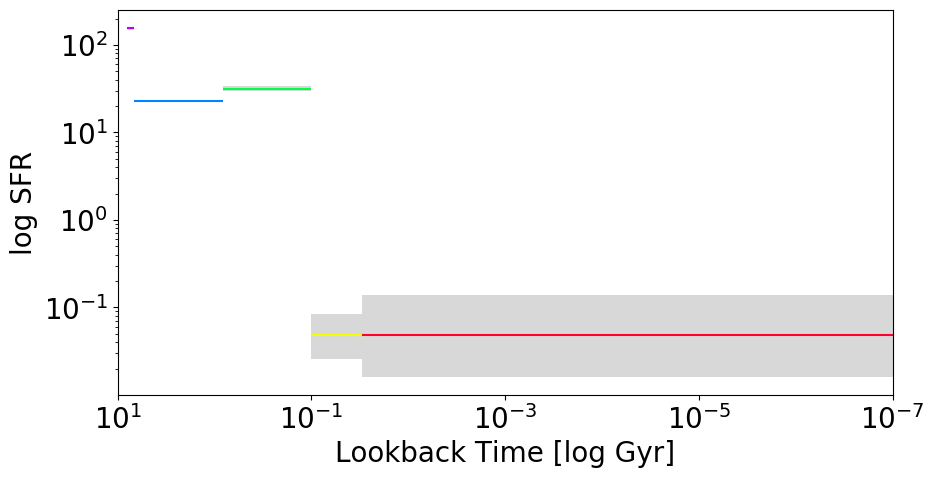

In [39]:
def logsfr_ratios_to_masses(logmass=None, logsfr_ratios=None, agebins=None,
                            **extras):
    """This converts from an array of log_10(SFR_j / SFR_{j+1}) and a value of
    log10(\Sum_i M_i) to values of M_i.  j=0 is the most recent bin in lookback
    time.
    """
    nbins = agebins.shape[0]
    sratios = 10**np.clip(logsfr_ratios, -100, 100) # numerical issues...
    dt = (10**agebins[:, 1] - 10**agebins[:, 0])
    coeffs = np.array([ (1. / np.prod(sratios[:i])) * (np.prod(dt[1: i+1]) / np.prod(dt[: i]))
                        for i in range(nbins)])
    m1 = (10**logmass) / coeffs.sum()

    return m1 * coeffs


def logsfr_ratios_to_sfrs(logmass=None, logsfr_ratios=None, agebins=None, **extras):
    """Convenience function
    """
    masses = logsfr_ratios_to_masses(logmass=logmass, logsfr_ratios=logsfr_ratios,
                                     agebins=agebins)
    dt = (10**agebins[:, 1] - 10**agebins[:, 0])

    return masses / dt

# 16th, 50th, and 84th percentiles of the posterior
from prospect.utils.plotting import quantile
flatchain = resn5["chain"]
post_pcts = [quantile(flatchain[:, i], percents=[16, 50, 84],
                                    weights=resn5.get("weights", None))
                      for i in range(modn5.ndim)]
#zred, logzsol, dust2, logmass, logsfrratios 1-4, dust_ratio, dust_index, gas_logz, gas_logu, spec_norm
#spec_jitter, f_outlier_spec, sigma_smooth

logsfr_ratios = []
logsfr_ratios_hi = []
logsfr_ratios_lo = []
for i in range(4):
    logsfr_ratios.append(post_pcts[i+4][1])
    logsfr_ratios_hi.append(post_pcts[i+4][2])
    logsfr_ratios_lo.append(post_pcts[i+4][0])
agebins = resn5['model_params'][8]['init']
M = post_pcts[3][1]
sfrs = logsfr_ratios_to_sfrs(logmass=M, logsfr_ratios=logsfr_ratios, agebins=agebins)
sfrs_hi = logsfr_ratios_to_sfrs(logmass=M, logsfr_ratios=logsfr_ratios_hi, agebins=agebins)
sfrs_lo = logsfr_ratios_to_sfrs(logmass=M, logsfr_ratios=logsfr_ratios_lo, agebins=agebins)

exes = list((10**agebins[:, 1])/10**9)
exes.insert(0, 0)
whys_lo = list(sfrs_lo)
whys_lo.insert(0, 0)
whys_hi = list(sfrs_hi)
whys_hi.insert(0, 0)
colormap = plt.cm.gist_rainbow
coloring = [colormap(i) for i in np.linspace(0, 0.9, len(agebins))]
plt.figure(figsize=(10,5))
plt.hlines(sfrs, (10**agebins[:, 0])/10**9, (10**agebins[:, 1])/10**9, colors=coloring)
# plt.hlines(sfrs_hi, 13.8-((10**agebins[:, 0])/10**9), 13.8-((10**agebins[:, 1])/10**9), colors='RED', lw=2, alpha=0.3)
# plt.hlines(sfrs_lo, 13.8-((10**agebins[:, 0])/10**9), 13.8-((10**agebins[:, 1])/10**9), colors='RED', lw=2, alpha=0.3)

plt.fill_between(exes,whys_lo, whys_hi, facecolor='grey', alpha=0.3, step='pre', edgecolor="none")

plt.yscale('log')
plt.xscale('log')
plt.xlim(10, 10**-7)
plt.xlabel("Lookback Time [log Gyr]", fontsize=20)
plt.ylabel("log SFR", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_xaxis()
plt.show()


<font color='mediumblue'>Caption: This figure shows the nonparametric star formation history determined by $\mathtt{Prospector}$. Each color shows the SFR for that time bin, with a total of 5 time bins, see the model section above for more details. The shaded grey regions show the 1$\sigma$ uncertainties for their respective time bins. All figures shown are for the same LEGA-C galaxy, which was determined in the literature to be a post-starburst galaxy. You can see that this SFH is consistent with that of a post-starburst galaxy. See [<font color='crimson'>Lecture 6</font> ](https://github.com/UA-ast502-2020/classnotebook/blob/master/lectures/ast502-lecture6.ipynb) of this class for the discussion of nonparametric modeling, including for star formation histories, lead by Zuyi Chen.</font>

## If $\mathtt{Prospector}$ looks like it could be useful for your research needs, feel free to contact me to discuss! I'm currently collaborating with other Steward folks on the use of this complicated tool and would love to collaborate with more.

Software:
* Prospector (Leja et al. 2017)
* python-fsps (Foreman-Mackey et al. 2014)
* astropy (Astropy  Collaboration  et  al.  2013,  2018)
* matplotlib (Caswell  et  al.  2018)
* dynesty (Speagle 2020)
* scipy (Virtanen et al. 2020)
* numpy (van der Walt et al. 2011)

References:
* Astropy Collaboration, Robitaille, T. P., Tollerud, E. J., et al. 2013, A&A, 558, A33, doi: 10.1051/0004-6361/201322068
* Astropy Collaboration, Price-Whelan, A. M., Sip ̋ocz, B. M., et al.2018, AJ, 156, 123, doi: 10.3847/1538-3881/aabc4f
* Caswell, T. A., Droettboom, M., Hunter, J., et al. 2018,matplotlib/matplotlib v3.0.0, v3.0.0, Zenodo,doi: 10.5281/zenodo.1420605
* Chabrier, G. 2003, PASP, 115, 763, doi: 10.1086/376392
* Conroy, C., Gunn, J. E., & White, M. 2009, ApJ, 699, 486,doi: 10.1088/0004-637X/699/1/486
* Draine, B. T., & Li, A. 2007, ApJ, 657, 810
* Foreman-Mackey, D., Sick, J., & Johnson, B. 2014, python-fsps: Python bindings to FSPS (v0.1.1), v0.1.1, Zenodo,doi: 10.5281/zenodo.12157
* Kriek, M., & Conroy, C. 2013, ApJL, 775, L16
* Leja, J., Johnson, B. D., Conroy, C., van Dokkum, P. G., & Byler, N. 2017, ApJ, 837, 170, doi: 10.3847/1538-4357/aa5ffe
* Skilling J., 2004, in Fischer R., Preuss R., Toussaint U. V., eds, AIP Conf.Proc. Vol. 735, Bayesian Inference and Maximum Entropy Methods inScience and Engineering. Am. Inst. Phys., New York, p. 395
* Skilling J., 2006,Bayesian Anal., 1, 833
* Speagle, J. S. 2020, MNRAS, doi: 10.1093/mnras/staa278
* van der Walt, S., Colbert, S. C., & Varoquaux, G. 2011, Computing in Science and Engineering, 13, 22, doi: 10.1109/MCSE.2011.37
* Virtanen, P., Gommers, R., Oliphant, T. E., et al. 2020, NatureMethods, doi: 10.1038/s41592-019-0686-2